### Imports & Data Load

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text

In [58]:
# Load Mushroom dataset
# The dataset contains 22 features, which are all categorical
df = pd.read_csv('mushrooms.csv')

# Split into features and target
X = df.drop('class', axis=1)
y = df['class']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, train_size=0.8, random_state=42)

# List of categorical columns
categorical_cols = X.columns.tolist()

In [59]:
df.head(10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
6,e,b,s,w,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,n,m
7,e,b,y,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,s,m
8,p,x,y,w,t,p,f,c,n,p,...,s,w,w,p,w,o,p,k,v,g
9,e,b,s,y,t,a,f,c,b,g,...,s,w,w,p,w,o,p,k,s,m


In [60]:
X_train.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [61]:
X_test.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
4632,x,y,g,f,f,f,c,b,p,e,...,k,p,n,p,w,o,l,h,y,d
3444,x,s,w,f,c,f,c,n,u,e,...,s,w,w,p,w,o,p,n,s,d
1209,x,f,w,f,n,f,w,b,p,t,...,s,w,w,p,w,o,e,n,s,g
6880,f,s,e,f,f,f,c,n,b,t,...,s,w,w,p,w,o,e,w,v,p
4542,x,f,y,f,f,f,c,b,g,e,...,k,p,n,p,w,o,l,h,y,g


---
### Problem 5 — Decision-Tree Parameter Sweep

In [62]:
def tree_sweep(train_X, train_y, test_X, test_y, 
               size=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               purity=[60, 65, 70, 75, 80, 85, 90, 95]):
    
    # OneHotEncoder for categorical columns
    ct = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

    # List to store results
    records = []
    for s in size:
        for p in purity:
            # Create a pipeline with preprocessing and a decision tree classifier
            pipe = Pipeline([
                ('prep', ct),  # preprocessing
                ('clf', DecisionTreeClassifier(
                    criterion='entropy',  # use entropy as the splitting criterion
                    max_leaf_nodes=s,  # limit the number of leaf nodes
                    min_impurity_decrease=p/100.0,  # limit the impurity decrease
                    random_state=42
                    ))])  # set a random seed for reproducibility
            
            # Train the model
            pipe.fit(train_X, train_y)

            # Evaluate the model on the training and test sets
            acc_tr = pipe.score(train_X, train_y)
            acc_te = pipe.score(test_X, test_y)

            # Store the results
            records.append((s, p, acc_tr, acc_te, pipe))

    # Create a DataFrame from the results
    cols = ['size','purity','Train Acc','Test Acc','model']
    return pd.DataFrame(records, columns=cols)

In [63]:
# Perform grid search over max_leaf_nodes and min_impurity_decrease
# Save results to a CSV file
# Show the first few rows of the results
sweep_df = tree_sweep(X_train, y_train, X_test, y_test)
sweep_df.drop(columns='model').to_csv('tree_sweep.csv', index=False)
sweep_df.head()

,size,purity,Train Acc,Test Acc,model
0,10,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
1,10,65,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
2,10,70,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
3,10,75,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
4,10,80,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."


In [64]:
sweep_df.groupby(['size'])['Test Acc'].value_counts().reset_index()

,size,Test Acc,count
0,10,0.518154,8
1,20,0.518154,8
2,30,0.518154,8
3,40,0.518154,8
4,50,0.518154,8
5,60,0.518154,8
6,70,0.518154,8
7,80,0.518154,8
8,90,0.518154,8
9,100,0.518154,8


In [65]:
sweep_df.groupby(['purity'])['Test Acc'].value_counts().reset_index()

,purity,Test Acc,count
0,60,0.518154,10
1,65,0.518154,10
2,70,0.518154,10
3,75,0.518154,10
4,80,0.518154,10
5,85,0.518154,10
6,90,0.518154,10
7,95,0.518154,10


#### Optimal Tree & Rules

In [66]:
# Find the best model based on the test accuracy
best_row = sweep_df.loc[sweep_df['Test Acc'].idxmax()]
best_model = best_row['model']

# Print the optimal hyperparameters and test accuracy
print(  'Optimal – size', int(best_row['size'])
      , 'purity', int(best_row['purity'])
      , 'Test Acc', best_row['Test Acc']
      )

# Extract the decision tree rules
tree_rules = export_text(best_model['clf'], feature_names=list(best_model['prep'].get_feature_names_out()))
print(tree_rules)

Optimal – size 10 purity 60 Test Acc 0.5181538461538462
|--- class: e



In [67]:
# Plot curves at optimal settings
# opt_size and opt_purity are the values of size and purity that gave the best test accuracy
opt_size = int(best_row['size'])
opt_purity = int(best_row['purity'])

In [68]:
sweep_df[sweep_df['size']==opt_size]

,size,purity,Train Acc,Test Acc,model
0,10,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
1,10,65,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
2,10,70,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
3,10,75,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
4,10,80,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
5,10,85,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
6,10,90,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
7,10,95,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."


In [69]:
sweep_df[sweep_df['purity']==opt_purity]

,size,purity,Train Acc,Test Acc,model
0,10,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
8,20,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
16,30,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
24,40,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
32,50,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
40,60,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
48,70,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
56,80,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
64,90,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."
72,100,60,0.517926,0.518154,"(ColumnTransformer(transformers=[('cat', OneHo..."


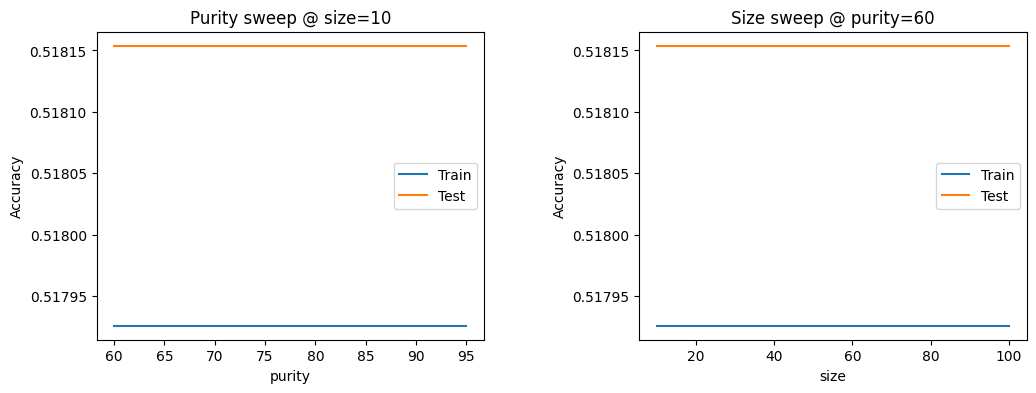

In [70]:
# create a figure with two subplots
fig, axes = plt.subplots(1,2, figsize=(12,4))

# plot the training and test accuracy when purity is varied at the optimal size
sns.lineplot(data=sweep_df[sweep_df['size']==opt_size], x='purity', y='Train Acc', ax=axes[0], label='Train')
sns.lineplot(data=sweep_df[sweep_df['size']==opt_size], x='purity', y='Test Acc', ax=axes[0], label='Test')
axes[0].set_title(f'Purity sweep @ size={opt_size}')
axes[0].set_ylabel('Accuracy')

# plot the training and test accuracy when size is varied at the optimal purity
sns.lineplot(data=sweep_df[sweep_df['purity']==opt_purity], x='size', y='Train Acc', ax=axes[1], label='Train')
sns.lineplot(data=sweep_df[sweep_df['purity']==opt_purity], x='size', y='Test Acc', ax=axes[1], label='Test')
axes[1].set_title(f'Size sweep @ purity={opt_purity}')
axes[1].set_ylabel('Accuracy')

# create a gap between the two graphs
fig.subplots_adjust(wspace=0.4)

# show the plot
plt.show()